# Problem 1

Recall that for the original GAN, the discriminator $f_\phi(x)$ is trained with the following optimization:

$$\max_\phi p(x) \log [f_\phi(x)] + q_\theta(x) \log [1 - f_\phi(x)]$$

where $p(x)$ is the true data distribution, $q_\theta(x)$ is the generator's learned distribution, and $f_\phi(x) \in [0, 1]$.

1. Assuming $q_\theta(x)$ is fixed, what is the solution to this optimization problem? "Solution" here means the function $f_\phi(x)$ that maximizes the above objective. Your expression should be in terms of $p(x)$ and $q_\theta(x)$.

**Written Answer:**

We can solve for the optimal solution by differentiation with respect to $f_{\phi}(x)$

$$ \frac{\partial}{\partial f_{\phi}(x)}[p(x)\log(f_{\phi}(x)) + q_{\theta}(x)\log[1 - f_{\phi}(x)]] = \frac{p(x)}{f_{\phi}(x)} - \frac{q_{\theta}(x)}{1 - f_{\phi}(x)} = 0$$
$$ \frac{p(x)}{f_{\phi}(x)} = \frac{q_{\theta}(x)}{1 - f_{\phi}(x)} $$
$$ p(x) - p(x)f_{\phi}(x) = q_{\theta}(x){f_{\phi}(x)} $$
$$ \frac{p(x)}{f_{\phi}(x)} = p(x) + q_{\theta}(x) $$
$$ f_{\phi}(x) =  \frac{p(x)}{p(x) + q_{\theta}(x)}$$
$$ $$ 

2. Assume that $q_\theta(x) = p(x)$, i.e. the generator has learned to fit the data distribution perfectly. What is the optimal discriminator in this case?

If $q_{\theta}$ is equal to p(x), and the generator learns the true data distribution perfectly then the optimal discriminator is equal to 1/2. This basically means that when presented with a sample and asked to predict if it is authentic or generated, the discriminatory applies a 50:50 weight to the decision. This minimizes the expected error or empirical risk of the model because any other value would have a greater expected error. For a single sample it might appear that other discriminators work better, however.

# Problem 2

Consider the following min-max optimization problem: $\min_x \max_y xy$.

1. Is there a stationary point to the function $xy$ (i.e. a point where $\frac{\partial xy}{\partial x} = 0$ and $\frac{\partial xy}{\partial y} = 0$)? If so, what is it?



**Written Answer:** The only stationary stable point in the above system is the point 0,0. 

2. Consider tackling this optimization problem with alternating gradient descent (i.e. alternatingly minimizing with respect to $x$ and maximizing with respect to $y$ using gradient descent). Assume that the learning rate is the same for both steps and that optimization begins from the point $x = 1, y = 1$. Will optimization reach a stationary point? Feel free to support your answer theoretically and/or empirically (i.e. by implementing it in code).


**Written Answer**: By alternating gradient descent and ascent on x and y, respectively, we will not be able to reach a stationary point. This is because from their starting at a positive nonzer value, x and y cannot both reach 0,0 which we previously identified as the only stationary (fixed stable point) in this system.



# Problem 3

The code below is taken from [the example in the textbook](http://d2l.ai/chapter_generative-adversarial-networks/gan.html). I've modified the example so that the true data distribution is a mixture of two Gaussians rather than a single Gaussian. Feel free to use the Pytorch code in this problem instead, but make sure you keep my modification to the data distribution.

The code below uses the original GAN loss. A somewhat popular alternative loss function is the ["Least-Squares GAN (LS-GAN)"](https://arxiv.org/pdf/1611.04076.pdf), which is defined as follows:

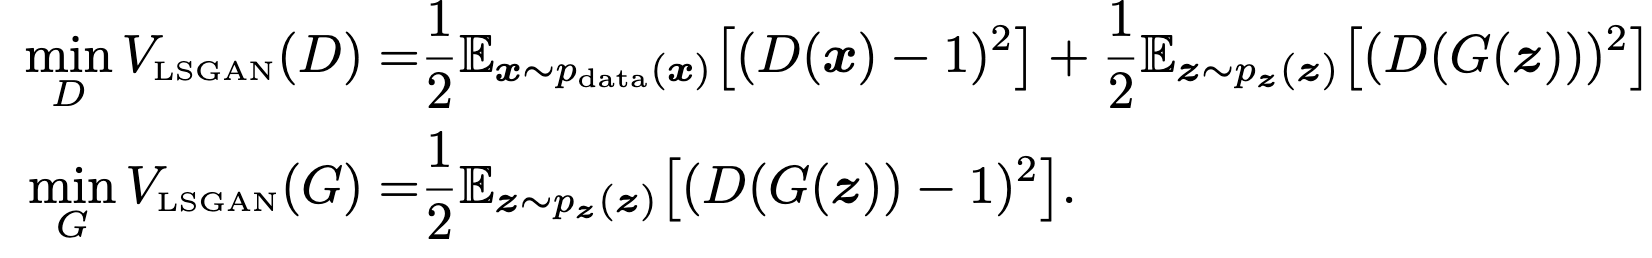

Modify the code so that it uses the LS-GAN objective instead of the original GAN objective. Does it converge to a different solution?

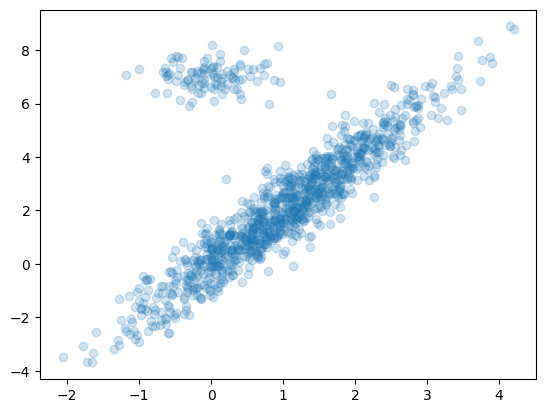

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn

# Do not change this part! It is different from the example in the textbook.
X = np.random.normal(0.0, 1, (1000, 2))
A = np.array([[1, 2], [-0.1, 0.5]])
b = np.array([1, 2])
data = np.concatenate([np.dot(X, A) + b, np.random.normal(0.0, 0.5, (100, 2)) + np.array([0, 7])], 0)
np.random.shuffle(data)
data = torch.tensor(data, dtype=torch.float32)
plt.scatter(data[:, 0].numpy(), data[:, 1].numpy(), alpha=0.2)

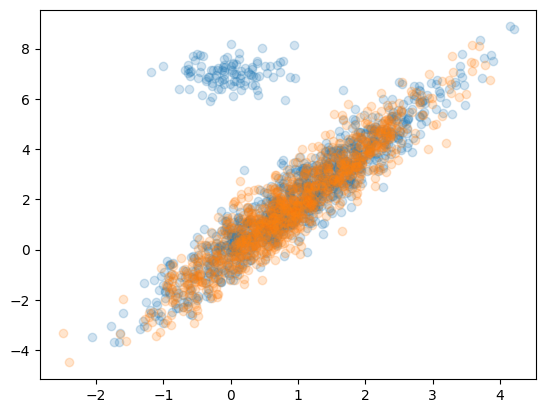

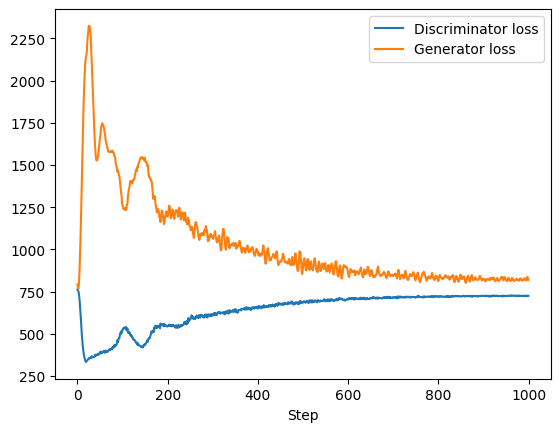

In [ ]:
net_G = nn.Sequential(nn.Linear(2, 2))

net_D = nn.Sequential(
    nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1))

def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +
              loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G

def train(net_D, net_G, num_steps, lr_D, lr_G, latent_dim, data, loss = nn.BCEWithLogitsLoss(reduction='sum')):
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
    losses_D, losses_G = [], []
    for epoch in range(num_steps):
        batch_size = data.shape[0]
        Z = torch.normal(0, 1, size=(batch_size, latent_dim))
        losses_D.append(update_D(data, Z, net_D, net_G, loss, trainer_D).detach().numpy())
        losses_G.append(update_G(Z, net_D, net_G, loss, trainer_G).detach().numpy())
    # Visualize generated examples
    Z = torch.normal(0, 1, size=(1000, latent_dim))
    fake_X = net_G(Z).detach().numpy()
    plt.figure()
    plt.scatter(data.detach().numpy()[:, 0], data.detach().numpy()[:, 1], alpha=0.2)
    plt.scatter(fake_X[:, 0], fake_X[:, 1], alpha=0.2)
    plt.figure()
    plt.plot(losses_D, label="Discriminator loss")
    plt.plot(losses_G, label="Generator loss")
    plt.legend()
    plt.xlabel("Step")

lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 1000
train(net_D, net_G, num_epochs, lr_D, lr_G, latent_dim, data)

### Contrastive Adversarial Loss

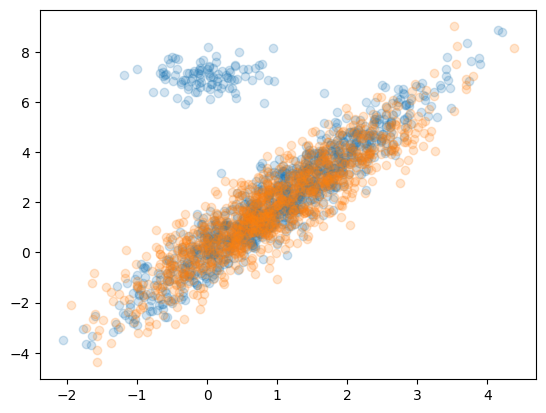

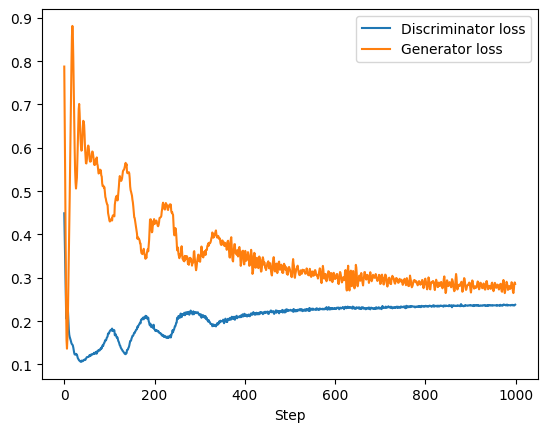

In [ ]:
net_G = nn.Sequential(nn.Linear(2, 2))

net_D = nn.Sequential(
    nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1))


lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 1000
train(net_D, net_G, num_epochs, lr_D, lr_G, latent_dim, data, loss=nn.MSELoss())